In [1]:
# Cell 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, hamming_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, coverage_error
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import get_scheduler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.sparse import csr_matrix
from tqdm import tqdm
import logging
import spacy
from negspacy.negation import Negex
from negspacy.termsets import termset
from imblearn.over_sampling import SMOTE
from focal_loss import BinaryFocalLoss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
import networkx as nx  # For graph-based label co-occurrence modeling
import joblib

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
ts = termset("en_clinical")
nlp.add_pipe("negex", config={"neg_termset": ts.get_patterns()})

2024-11-21 19:28:08,680 - INFO - Using device: cuda


In [2]:
# Cell 2: Data Loading and Merging
def load_and_merge_data(file_paths):
    try:
        logger.info("Loading data files...")
        radiology_df = pd.read_csv(file_paths[0], usecols=['subject_id', 'note_id', 'hadm_id', 'text'])
        radiology_detail_df = pd.read_csv(file_paths[1], usecols=['subject_id', 'note_id', 'field_name', 'field_value'])
        diagnoses_icd_df = pd.read_csv(file_paths[2], usecols=['subject_id', 'hadm_id', 'icd_code'])
        patients_df = pd.read_csv(file_paths[3], usecols=['subject_id', 'gender', 'anchor_age'])
        admissions_df = pd.read_csv(file_paths[4], usecols=['subject_id', 'hadm_id', 'admission_type', 'insurance'])

        logger.info("Files loaded successfully")

        radiology_df.drop_duplicates(subset=['subject_id', 'note_id'], inplace=True)
        radiology_detail_df.drop_duplicates(subset=['subject_id', 'note_id'], inplace=True)
        diagnoses_icd_df.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)
        patients_df.drop_duplicates(subset=['subject_id'], inplace=True)
        admissions_df.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)

        # Filter for top 10 most frequent ICD codes
        icd_counts = diagnoses_icd_df['icd_code'].value_counts()
        top_10_icd = icd_counts.head(10).index.tolist()
        diagnoses_icd_df = diagnoses_icd_df[diagnoses_icd_df['icd_code'].isin(top_10_icd)]

        logger.info("Merging dataframes...")
        df = pd.merge(radiology_df, radiology_detail_df, on=['subject_id', 'note_id'], how='inner')
        df = pd.merge(df, diagnoses_icd_df, on=['subject_id', 'hadm_id'], how='inner')
        df = pd.merge(df, patients_df, on=['subject_id'], how='inner')
        df = pd.merge(df, admissions_df, on=['subject_id', 'hadm_id'], how='inner')

        # Debug: Check class distribution
        logger.info(f"Class distribution: {df['icd_code'].value_counts()}")

        logger.info("Dataframes merged successfully")
        return df

    except Exception as e:
        logger.error(f"Error: {e}")
        return None

file_paths = [
    'radiology.csv',
    'radiology_detail.csv',
    'diagnoses_icd.csv',
    'patients.csv',
    'admissions.csv'
]

df = load_and_merge_data(file_paths)

2024-11-21 19:28:09,126 - INFO - Loading data files...
2024-11-21 19:28:38,208 - INFO - Files loaded successfully
2024-11-21 19:28:40,527 - INFO - Merging dataframes...
2024-11-21 19:28:43,004 - INFO - Class distribution: icd_code
A419     22012
41401    14136
486       9974
5849      8393
78650     7735
78659     5967
Z5111     2360
30500     1877
311        507
F329       500
Name: count, dtype: int64
2024-11-21 19:28:43,006 - INFO - Dataframes merged successfully


In [3]:
# Cell 3: Text Preprocessing
def preprocess_text(text):
    doc = nlp(text.lower())
    negex = nlp.get_pipe("negex")
    negated_tokens = []
    for ent in doc.ents:
        if ent._.negex:
            negated_tokens.append("NOT_" + ent.text)
        else:
            negated_tokens.append(ent.text)
    return ' '.join(negated_tokens)

def preprocess_data(df):
    tqdm.pandas()

    logger.info("Preprocessing data...")
    df['processed_text'] = df['text'].progress_apply(preprocess_text)
    df['icd_codes'] = df['icd_code'].str.split(',')
    df = df.dropna(subset=['icd_codes'])
    df['anchor_age'] = pd.to_numeric(df['anchor_age'], errors='coerce')
    
    numeric_columns = ['anchor_age']
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    categorical_columns = ['gender', 'admission_type', 'insurance']
    df = pd.get_dummies(df, columns=categorical_columns)

    logger.info(f"Preprocessed dataset shape: {df.shape}")
    return df

df = preprocess_data(df)
df.head() 

2024-11-21 19:28:43,299 - INFO - Preprocessing data...
100%|██████████| 73461/73461 [21:24<00:00, 57.20it/s]
2024-11-21 19:50:07,709 - INFO - Preprocessed dataset shape: (73461, 26)


,note_id,subject_id,hadm_id,text,field_name,field_value,icd_code,anchor_age,processed_text,icd_codes,...,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,insurance_Medicaid,insurance_Medicare,insurance_No charge,insurance_Other,insurance_Private
0,10001338-RR-39,10001338,29335220.0,INDICATION: Chest pressure. Please evaluate ...,exam_code,C11,78650,-1.296402,,[78650],...,True,False,False,False,False,False,False,False,False,True
1,10001884-RR-100,10001884,25758848.0,HISTORY: Cough and shortness of breath with r...,exam_code,C11,486,0.307635,emphysema asymmetric,[486],...,True,False,False,False,False,False,True,False,False,False
2,10001884-RR-82,10001884,21268656.0,INDICATION: ___ female with chest pain.\n\n__...,exam_code,C11,41401,0.307635,,[41401],...,False,True,False,False,False,False,True,False,False,False
3,10001884-RR-83,10001884,26679629.0,CHEST RADIOGRAPH PERFORMED ON ___\n\nCompariso...,exam_code,C11,78659,0.307635,emphysema,[78659],...,False,True,False,False,False,False,True,False,False,False
4,10001884-RR-97,10001884,26812645.0,"INDICATION: Intermittent chest pain, evaluate...",exam_code,C11,78650,0.307635,,[78650],...,True,False,False,False,False,False,True,False,False,False


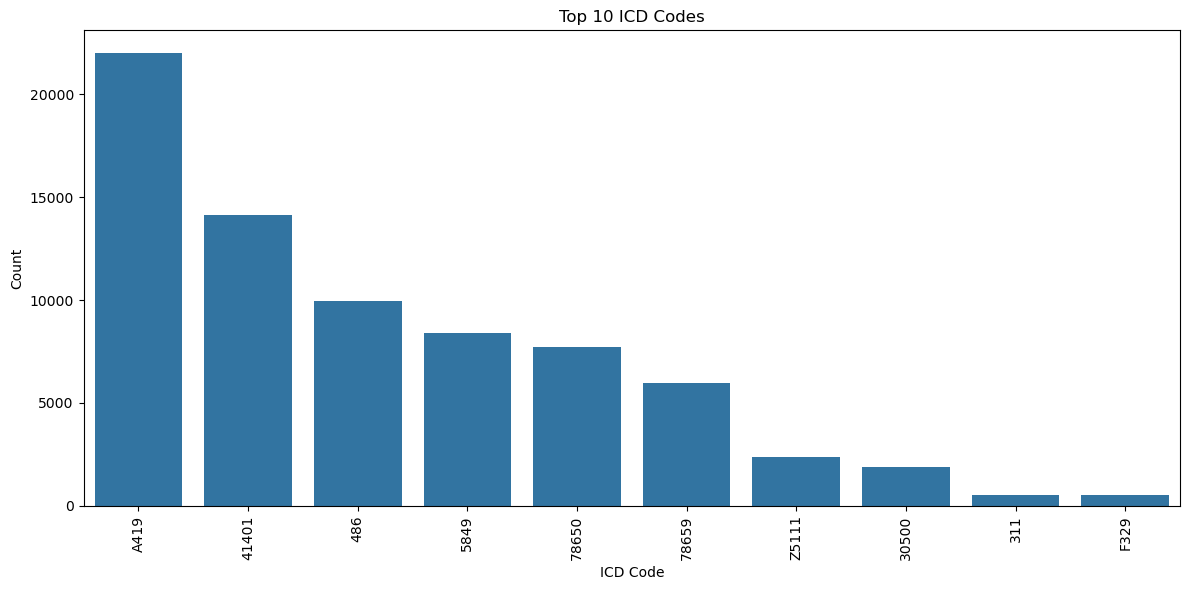

2024-11-21 19:50:07,902 - INFO - Plotting label co-occurrence matrix...


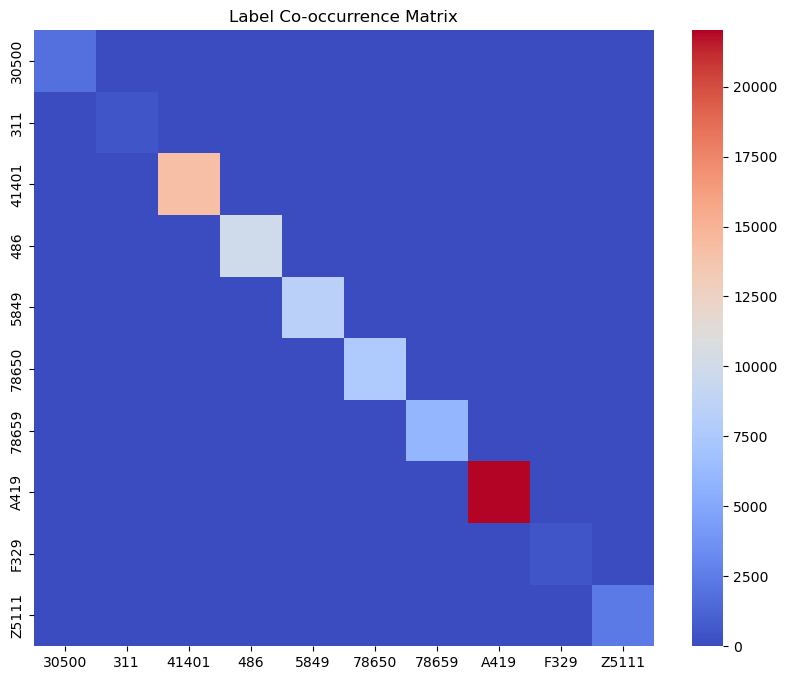

In [4]:
# Cell 4: Exploratory Data Analysis (EDA)
def perform_eda(df):
    icd_counts = df['icd_codes'].explode().value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=icd_counts.index[:20], y=icd_counts.values[:20])
    plt.title('Top 10 ICD Codes')
    plt.xlabel('ICD Code')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

perform_eda(df)

def plot_label_cooccurrence_matrix(df):
    logger.info("Plotting label co-occurrence matrix...")
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['icd_codes'])
    cooccurrence_matrix = np.dot(y.T, y)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=False, cmap='coolwarm', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
    plt.title("Label Co-occurrence Matrix")
    plt.show()

plot_label_cooccurrence_matrix(df)

In [5]:
# Cell 5: Get BioClinicalBERT Embeddings
def get_embeddings_with_new_model(
    texts,
    model_name='emilyalsentzer/Bio_ClinicalBERT',  # Replace with Longformer if needed
    batch_size=16,
    max_length=512
):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    # Ensure input is a list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    elif not isinstance(texts, list):
        raise ValueError("Input must be a string, a list of strings, or a numpy array of strings.")

    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc=f"Generating embeddings with {model_name}"):
            batch_texts = texts[i:i + batch_size]

            # Tokenize and prepare inputs
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=max_length
            ).to(device)

            # Generate model outputs
            outputs = model(**inputs)

            # Use the mean of the last hidden states as embeddings
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Replace the following with your preferred model
df['embeddings'] = list(get_embeddings_with_new_model(df['processed_text'].tolist(), model_name='emilyalsentzer/Bio_ClinicalBERT'))

Generating embeddings with emilyalsentzer/Bio_ClinicalBERT: 100%|██████████| 4592/4592 [01:35<00:00, 48.08it/s]


In [6]:
# Cell 6: Dynamic Hierarchical Attention Mechanism and Model Definition
# Optimized RadiologyDataset class
class RadiologyDataset(Dataset):
    def __init__(self, features, labels, categories):
        self.features = torch.tensor(np.vstack(features), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.categories = torch.tensor(categories, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.categories[idx]


# Optimized HierarchicalAttentionLayer
class HierarchicalAttentionLayer(nn.Module):
    def __init__(self, input_dim, num_categories, num_heads=4, dropout=0.2):
        super(HierarchicalAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.input_dim = input_dim

        # Category-level multi-head attention
        self.category_attention_heads = nn.ModuleList(
            [nn.Linear(input_dim, 1, bias=False) for _ in range(num_heads)]
        )

        # Subcategory-level multi-head attention
        self.subcategory_attention_heads = nn.ModuleList(
            [nn.Linear(input_dim, 1, bias=False) for _ in range(num_heads)]
        )

        # Dropout layers for regularization
        self.category_dropout = nn.Dropout(dropout)
        self.subcategory_dropout = nn.Dropout(dropout)

        # Residual connections and normalization layers
        self.category_norm = nn.LayerNorm(input_dim)
        self.subcategory_norm = nn.LayerNorm(input_dim)

        # Linear projections for category and subcategory representations
        self.category_projection = nn.Linear(input_dim, num_categories, bias=False)
        self.subcategory_projection = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)

        # Category-level multi-head attention
        category_scores = torch.mean(
            torch.stack(
                [torch.softmax(head(x), dim=1) for head in self.category_attention_heads],
                dim=-1
            ),
            dim=-1
        )
        category_scores = self.category_dropout(category_scores)
        category_representation = torch.sum(x * category_scores, dim=1)
        category_representation = self.category_norm(category_representation + torch.mean(x, dim=1))
        category_representation = self.category_projection(category_representation)

        # Subcategory-level multi-head attention
        subcategory_scores = torch.mean(
            torch.stack(
                [torch.softmax(head(x), dim=1) for head in self.subcategory_attention_heads],
                dim=-1
            ),
            dim=-1
        )
        subcategory_scores = self.subcategory_dropout(subcategory_scores)
        subcategory_representation = torch.sum(x * subcategory_scores, dim=1)
        subcategory_representation = self.subcategory_norm(
            subcategory_representation + torch.mean(x, dim=1)
        )
        subcategory_representation = self.subcategory_projection(subcategory_representation)

        # Combine category and subcategory representations
        combined_representation = torch.cat([category_representation, subcategory_representation], dim=-1)
        return combined_representation, category_scores, subcategory_scores


# Optimized ICDClassifierWithHierarchicalAttention
class ICDClassifierWithHierarchicalAttention(nn.Module):
    def __init__(self, input_dim, num_categories, num_subcategories):
        super(ICDClassifierWithHierarchicalAttention, self).__init__()

        # Hierarchical Attention Layer with Multi-Head Attention
        self.hierarchical_attention = HierarchicalAttentionLayer(input_dim, num_categories, num_heads=8, dropout=0.3)

        # Fully connected layers with increased dropout and normalization
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim + num_categories, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LayerNorm(2048)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LayerNorm(1024)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LayerNorm(512)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LayerNorm(256)
        )

        # Residual projections for enhanced learning
        self.residual_projection1 = nn.Linear(2048, 1024)
        self.residual_projection2 = nn.Linear(1024, 512)
        self.residual_projection3 = nn.Linear(512, 256)

        # Output layer
        self.output_layer = nn.Linear(256, num_subcategories)

    def forward(self, x):
        combined_representation, category_scores, subcategory_scores = self.hierarchical_attention(x)

        # Fully connected layers with residual connections
        x = self.fc1(combined_representation)
        residual1 = x
        x = self.fc2(x)
        x += self.residual_projection1(residual1)

        residual2 = x
        x = self.fc3(x)
        x += self.residual_projection2(residual2)

        residual3 = x
        x = self.fc4(x)
        x += self.residual_projection3(residual3)

        output = self.output_layer(x)
        return output, category_scores, subcategory_scores

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


# Focal Loss with fine-tuned alpha and gamma
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            F_loss = alpha_t * F_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [7]:
# Cell 7: Train/Test Split with Category Information
from sklearn.utils import resample
# Prepare datasets with categories
def prepare_datasets_with_smote(df, test_size=0.2, random_state=42):
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['icd_codes'])

    # Create categories (high-level groupings for ICD codes)
    df['categories'] = df['icd_codes'].apply(lambda x: [icd[:3] for icd in x])  # Group by first 3 characters
    category_mlb = MultiLabelBinarizer()
    categories = category_mlb.fit_transform(df['categories'])

    # Convert embeddings to a NumPy array
    X = np.vstack(df['embeddings'].tolist())

    # Resample each label independently using SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled_list, y_resampled_list = [], []

    for i in range(y.shape[1]):
        y_single = y[:, i]  # Extract a single label
        X_resampled, y_resampled = smote.fit_resample(X, y_single)
        X_resampled_list.append(X_resampled)
        y_resampled_list.append(y_resampled)

    # Calculate the maximum size among all resampled datasets
    max_size = max([arr.shape[0] for arr in X_resampled_list])

    # Align dimensions by padding smaller datasets
    X_resampled_aligned = np.zeros((max_size, X.shape[1]))
    y_resampled_aligned = np.zeros((max_size, y.shape[1]))

    for i in range(y.shape[1]):
        current_size = X_resampled_list[i].shape[0]
        X_resampled_aligned[:current_size] += X_resampled_list[i]
        y_resampled_aligned[:current_size, i] += y_resampled_list[i]

    # Resample categories (match the maximum size)
    _, categories_resampled = smote.fit_resample(X, categories)
    categories_resampled = categories_resampled[:max_size, :]

    # Splitting the dataset
    X_train, X_test, y_train, y_test, cat_train, cat_test = train_test_split(
        X_resampled_aligned, y_resampled_aligned, categories_resampled, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test, cat_train, cat_test, mlb, category_mlb

# Call the function to prepare datasets
X_train, X_test, y_train, y_test, cat_train, cat_test, mlb, category_mlb = prepare_datasets_with_smote(df)

# Create datasets
train_dataset = RadiologyDataset(X_train, y_train, cat_train)
test_dataset = RadiologyDataset(X_test, y_test, cat_test)

Epoch 1/30 [Validation]: 100%|██████████| 913/913 [00:02<00:00, 336.45it/s, Val Loss=0.0693]
2024-11-21 20:05:45,344 - INFO - Epoch 1/30
2024-11-21 20:05:45,345 - INFO - Train Loss: 0.3433, Train Accuracy: 0.8601
2024-11-21 20:05:45,346 - INFO - Val Loss: 0.3221, Val Accuracy: 0.8993
Epoch 2/30 [Validation]: 100%|██████████| 913/913 [00:02<00:00, 319.74it/s, Val Loss=0.0222]
2024-11-21 20:06:17,776 - INFO - Epoch 2/30
2024-11-21 20:06:17,776 - INFO - Train Loss: 0.2645, Train Accuracy: 0.9025
2024-11-21 20:06:17,777 - INFO - Val Loss: 0.2814, Val Accuracy: 0.9114
Epoch 3/30 [Validation]: 100%|██████████| 913/913 [00:02<00:00, 333.51it/s, Val Loss=0.13] 
2024-11-21 20:06:49,209 - INFO - Epoch 3/30
2024-11-21 20:06:49,210 - INFO - Train Loss: 0.2506, Train Accuracy: 0.9080
2024-11-21 20:06:49,210 - INFO - Val Loss: 0.2774, Val Accuracy: 0.9106
Epoch 4/30 [Validation]: 100%|██████████| 913/913 [00:02<00:00, 343.32it/s, Val Loss=0.0272]
2024-11-21 20:07:21,456 - INFO - Epoch 4/30
2024-11-2

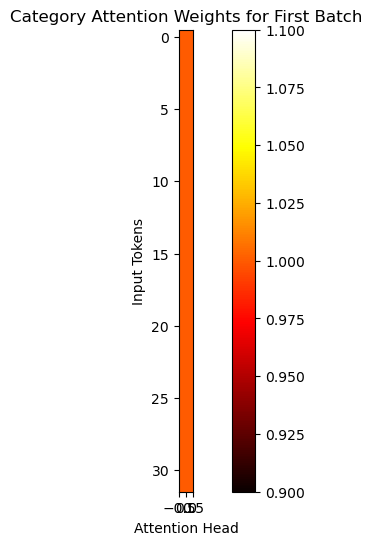

Final Test Set Evaluation Metrics:
Precision: 0.9496
Recall: 0.8855
F1 Score: 0.9164
ROC AUC: 0.9234
Hamming Loss: 0.0729


In [21]:
# Cell 8: Model Training 
def train_model_with_regularization(
    model,
    train_loader,
    val_loader,
    num_epochs,
    criterion,
    optimizer,
    scheduler=None,
    patience=3,
):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for batch_features, batch_labels, batch_categories in progress_bar:
            batch_features, batch_labels, batch_categories = (
                batch_features.to(device),
                batch_labels.to(device),
                batch_categories.to(device),
            )

            optimizer.zero_grad()
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()

            # Clip gradients to improve stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.numel()

            progress_bar.set_postfix({"Train Loss": loss.item()})

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')

        with torch.no_grad():
            for batch_features, batch_labels, batch_categories in val_progress_bar:
                batch_features, batch_labels, batch_categories = (
                    batch_features.to(device),
                    batch_labels.to(device),
                    batch_categories.to(device),
                )

                outputs, _, _ = model(batch_features)
                loss = criterion(outputs, batch_labels)
                running_loss += loss.item()

                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.numel()

                val_progress_bar.set_postfix({"Val Loss": loss.item()})

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Scheduler step for ReduceLROnPlateau
        if scheduler and isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)

        # Log metrics
        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        logger.info(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Load the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_accuracies, val_accuracies


# Grid search for custom thresholds per label
def tune_thresholds_per_label(y_true, y_probs, num_labels):
    best_thresholds = []
    for label_idx in range(num_labels):
        thresholds = np.linspace(0.1, 0.9, 9)
        best_f1 = 0
        best_thresh = 0.5
        for thresh in thresholds:
            preds = (y_probs[:, label_idx] > thresh).astype(float)
            f1 = f1_score(y_true[:, label_idx], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return best_thresholds


# Adjust evaluation function for attention visualization
def evaluate_model_with_attention_visualization(model, test_loader, mlb, thresholds):
    model.eval()
    all_preds, all_labels = [], []
    all_attention_weights = []

    with torch.no_grad():
        for batch_features, batch_labels, batch_categories in test_loader:
            batch_features = batch_features.to(device)
            outputs, category_scores, subcategory_scores = model(batch_features)
            probs = torch.sigmoid(outputs).cpu().numpy()

            preds = np.zeros_like(probs)
            for label_idx in range(probs.shape[1]):
                preds[:, label_idx] = (probs[:, label_idx] > thresholds[label_idx]).astype(float)

            all_preds.append(preds)
            all_labels.append(batch_labels.numpy())
            all_attention_weights.append((category_scores.cpu().numpy(), subcategory_scores.cpu().numpy()))

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_preds, average='micro', multi_class='ovo')
    loss = hamming_loss(all_labels, all_preds)

    logger.info(f"Evaluation Metrics:")
    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"Hamming Loss: {loss:.4f}")

    # Visualize attention weights for the first batch
    category_attention, subcategory_attention = all_attention_weights[0]
    plt.figure(figsize=(10, 6))
    plt.imshow(category_attention, cmap='hot', interpolation='nearest')
    plt.title('Category Attention Weights for First Batch')
    plt.xlabel('Attention Head')
    plt.ylabel('Input Tokens')
    plt.colorbar()
    plt.show()

    return precision, recall, f1, roc_auc, loss

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model dimensions
input_dim = 768
num_categories = category_mlb.classes_.shape[0]
num_subcategories = mlb.classes_.shape[0]

# Initialize the model
model = ICDClassifierWithHierarchicalAttention(input_dim, num_categories, num_subcategories).to(device)

# Use class-weighted BCEWithLogitsLoss for multi-label classification
class_weights = []
for i in range(y_train.shape[1]):
    label_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[:, i]
    )
    class_weights.append(label_weights[1])

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

# Define the optimizer with smaller initial learning rates
optimizer = torch.optim.AdamW([
    {"params": model.hierarchical_attention.parameters(), "lr": 1e-6, "weight_decay": 1e-6},
    {"params": model.fc1.parameters(), "lr": 1e-5, "weight_decay": 1e-4},
    {"params": model.fc2.parameters(), "lr": 1e-5, "weight_decay": 1e-4},
    {"params": model.fc3.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
    {"params": model.fc4.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
    {"params": model.output_layer.parameters(), "lr": 1e-4, "weight_decay": 1e-3}
])

# Define the learning rate scheduler: CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_regularization(
    model, train_loader, val_loader, num_epochs=30, criterion=criterion, optimizer=optimizer, scheduler=scheduler
)

# Save the model
torch.save(model.state_dict(), "final_model_with_regularization.pth")

# Load the model for evaluation
model.load_state_dict(torch.load("final_model_with_regularization.pth", map_location=device))

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
logger.info("Starting evaluation on test set...")
precision, recall, f1, roc_auc, hamming = evaluate_model_with_attention_visualization(
    model, test_loader, mlb, thresholds=[0.5] * num_subcategories
)

# Display final metrics
print(f"Final Test Set Evaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

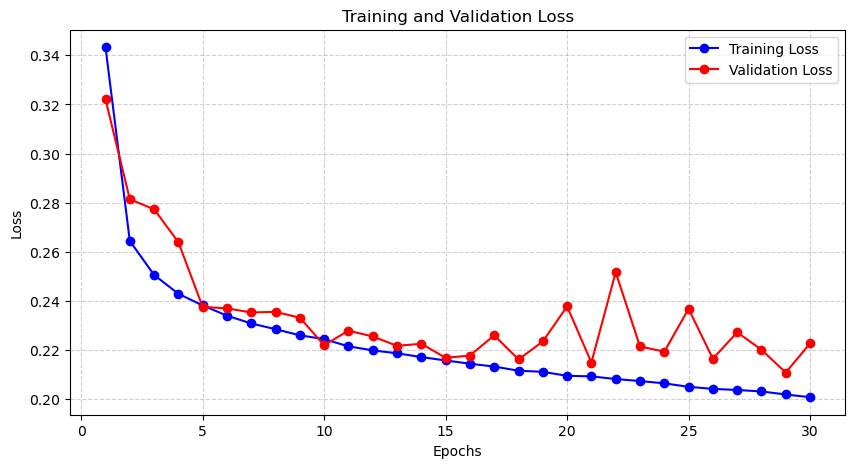

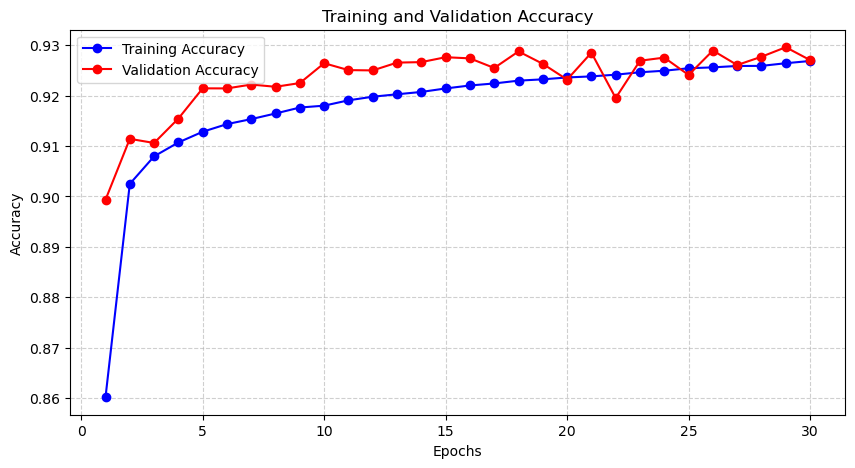

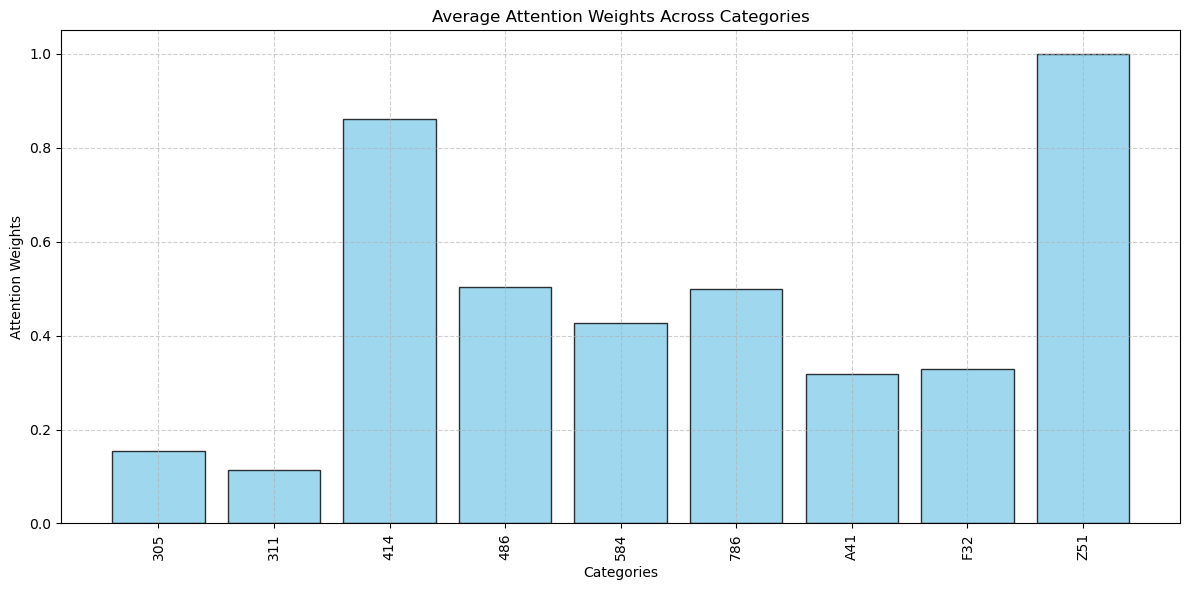

In [23]:
# Cell 9: Plotting Training/Validation Metrics
# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-', marker='o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', marker='o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, 'b-', marker='o', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', marker='o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Function to plot hierarchical attention weights
def plot_hierarchical_attention_weights(attention_weights, categories):
    """
    Plots average attention weights across all samples for each category.

    Args:
        attention_weights: numpy array or list containing attention weights.
        categories: list of category names.
    """
    if isinstance(attention_weights, list):
        avg_attention_weights = np.mean(attention_weights, axis=0)  # Average across samples
    else:
        avg_attention_weights = attention_weights

    if len(avg_attention_weights) != len(categories):
        raise ValueError(
            f"Mismatch between attention weights ({len(avg_attention_weights)}) and categories ({len(categories)})!"
        )

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(categories, avg_attention_weights, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title('Average Attention Weights Across Categories')
    plt.xlabel('Categories')
    plt.ylabel('Attention Weights')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example Usage:
# Plot training/validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Plot hierarchical attention weights
example_attention_weights = np.random.rand(len(category_mlb.classes_))  # Simulated attention weights
categories = category_mlb.classes_.tolist()  # Category names
plot_hierarchical_attention_weights(example_attention_weights, categories)

In [33]:
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer
from IPython.display import display, HTML


# LIME Explanation for High Probability Code
def interpret_model_with_lime_high_probability(model, full_text, mlb, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    
    def predict_proba(texts):
        # Convert text to BioClinicalBERT embeddings
        embeddings = torch.tensor(get_embeddings_with_new_model(texts, model_name='emilyalsentzer/Bio_ClinicalBERT')).to(device)
        
        # Ensure embedding shape is correct
        if len(embeddings.shape) == 2:
            embeddings = embeddings.unsqueeze(1)
        
        with torch.no_grad():
            outputs, _, _ = model(embeddings)
            return torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities

    # Get prediction probabilities
    probabilities = predict_proba([full_text])[0]
    max_prob_index = np.argmax(probabilities)
    max_prob_class = class_names[max_prob_index]
    max_prob_value = probabilities[max_prob_index]

    # Print highest probability code
    print(f"Highest probability code: {max_prob_class} ({max_prob_value:.2f})")

    # Generate LIME explanation for the highest probability class
    exp = explainer.explain_instance(
        full_text, predict_proba, num_features=50, labels=[max_prob_index]
    )

    # Display LIME visualization inline
    explanation_html = exp.as_html()
    display(HTML(explanation_html))


# Updated evaluation and explanation function
def evaluate_and_explain_model_full_text(model, test_loader, mlb, df):
    model.eval()
    all_preds, all_labels = [], []

    # Dynamically identify the column name for radiology text
    text_column = None
    for col in df.columns:
        if 'text' in col.lower():  # Look for a column containing "text" in its name
            text_column = col
            break
    
    if not text_column:
        raise KeyError("No column containing 'text' found in the DataFrame. Please check your data.")

    with torch.no_grad():
        for batch_features, batch_labels, batch_categories in test_loader:
            batch_features = batch_features.to(device)
            if len(batch_features.shape) == 2:
                batch_features = batch_features.unsqueeze(1)

            # Model prediction
            outputs, _, _ = model(batch_features)
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(batch_labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    precision = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_preds, average='micro')
    loss = hamming_loss(all_labels, all_preds)

    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"Hamming Loss: {loss:.4f}")

    # Use the full radiology report for LIME explanation
    full_text = df[text_column].sample(1).values[0]  # Dynamically use the identified column
    print("\nFull text selected for explanation:\n")
    print(full_text)

    # Use LIME for the highest probability code explanation
    interpret_model_with_lime_high_probability(model, full_text, mlb, mlb.classes_)

    return all_preds, all_labels


# Call the updated evaluation and explanation function
all_preds, all_labels = evaluate_and_explain_model_full_text(model, test_loader, mlb, df)

2024-11-21 20:40:14,051 - INFO - Precision: 0.9496
2024-11-21 20:40:14,052 - INFO - Recall: 0.8855
2024-11-21 20:40:14,052 - INFO - F1 Score: 0.9164
2024-11-21 20:40:14,053 - INFO - ROC AUC: 0.9234
2024-11-21 20:40:14,053 - INFO - Hamming Loss: 0.0729



Full text selected for explanation:

INDICATION:  Aortic valve and coronary artery bypass surgery, fast track
extubation.  Evaluate for pneumothorax, effusion.

COMPARISON:  Radiograph dated ___.

FINDINGS:  Lung volumes are low.  When compared to the preoperative
radiograph, there is prominence of the upper lobe vasculature, consistent with
acute pulmonary edema.  Mediastinal widening, particularly on the right side
is suggestive of mediastinal hematoma.  The tip of the endotracheal tube,
Swan-Ganz catheter, median sternotomy wires, nasogastric tube, bilateral chest
drains and mediastinal drain are in satisfactory position.  The cardiac size
is at the upper limits of normal.

IMPRESSION:
1.  Acute mild pulmonary edema postoperatively.
2.  Satisfactory position of medical devices.
3.  Probable mediastinal hematoma.



Generating embeddings with emilyalsentzer/Bio_ClinicalBERT: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Highest probability code: 41401 (0.29)


Generating embeddings with emilyalsentzer/Bio_ClinicalBERT: 100%|██████████| 313/313 [00:16<00:00, 18.55it/s]
